# Plant Nutrition Prediction
## Introduction
- Name: `Izzan Dienurrahman`
- Batch: HCK-003

## Objective
- Develop a regression model based on nutritional components information of plants that has been gathered from a laboratory experiment.

## Problem Statements
- The current understanding of the nutritional value of plants is insufficient.
- Laboratory experiments provide valuable data on plant nutrition.
- There is a need to develop a prediction model based on the nutritional information gathered from these experiments.
- The model must be accurate and reliable in forecasting the nutritional content of plants.
- Improving our knowledge of plant nutrition will have a positive impact on plant health and yield.


## Dataset Description
`aria_data.xlsx`
- **target** contained information to predict plant nutrition
- **V1 - V8** contained information about variable to predict plant nutrition
- **sample_type** contained information about 2 different labs sample obtained

## Import Libraries

In [1]:
# import all libraries needed for this project
import pandas as pd
import numpy as np
import joblib 
import phik
import tensorflow as tf
import seaborn as sns;sns.set()
import matplotlib.pyplot as plt
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from tensorflow import keras
from tensorflow_addons.metrics import RSquare
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

## Data Loading

In [2]:
# read files into pandas dataframe
df = pd.read_excel('aria_data.xlsx')

In [3]:
# show top 5 data entries
df.head()

,target,v1,v2,v3,v4,v5,v6,v7,v8,sample_type
0,4.63,260.600000,199.000000,391.333333,371.733333,466.800000,273.133333,742.066667,4047.733333,lab 1
1,5.00,263.200000,194.600000,393.666667,348.533333,401.800000,220.066667,712.000000,4673.466667,lab 1
2,4.91,247.266667,205.800000,375.466667,354.866667,419.000000,222.133333,677.200000,4386.800000,lab 1
3,4.77,257.944444,191.833333,368.722222,334.666667,417.222222,195.944444,678.555556,4588.777778,lab 1
4,4.89,258.200000,195.733333,356.666667,333.333333,394.600000,196.000000,677.133333,4867.066667,lab 1


In [4]:
# show bottom 5 data entries
df.tail()

,target,v1,v2,v3,v4,v5,v6,v7,v8,sample_type
155,4.83,573.2500,361.250000,643.125000,489.812500,666.875,355.250000,712.312500,3943.687500,lab 2
156,4.47,678.3750,398.125000,678.250000,541.125000,704.000,393.500000,788.812500,3928.187500,lab 2
157,4.63,634.0000,382.866667,657.466667,505.066667,719.200,366.600000,792.133333,3861.200000,lab 2
158,4.35,615.3125,366.750000,642.937500,483.687500,675.625,359.062500,730.125000,3859.062500,lab 2
159,4.43,575.2000,350.266667,648.333333,495.400000,679.800,346.266667,718.733333,3903.333333,lab 2


In [5]:
# show brief info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   target       160 non-null    float64
 1   v1           160 non-null    float64
 2   v2           160 non-null    float64
 3   v3           160 non-null    float64
 4   v4           160 non-null    float64
 5   v5           160 non-null    float64
 6   v6           160 non-null    float64
 7   v7           160 non-null    float64
 8   v8           160 non-null    float64
 9   sample_type  160 non-null    object 
dtypes: float64(9), object(1)
memory usage: 12.6+ KB


There are **160** entries of data with **10** columns and there are no missing values. All data are of the numerical type except `sample_type`.

In [6]:
# show duplicated data
df.duplicated().sum()

0

There is no duplicated data either.

## Exploratory Data Analysis (EDA)

In [7]:
# describe data with common stats such as count, min, max, etc.
df.describe()

,target,v1,v2,v3,v4,v5,v6,v7,v8
count,160.00000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000
mean,4.73375,389.892437,237.442677,480.573041,394.109622,487.316520,251.450820,714.737926,4456.913233
std,0.21405,148.673511,70.128690,118.798984,63.060442,100.941711,59.634652,51.148098,335.035933
min,4.13000,227.285714,178.800000,348.933333,313.733333,373.333333,189.200000,586.266667,3725.666667
25%,4.60000,268.608333,194.029018,384.419643,353.181250,418.583333,213.000000,678.385417,4273.437500
50%,4.72000,295.162500,204.187500,414.383929,370.741667,456.031250,226.062500,718.833333,4554.766667
75%,4.89000,536.409375,244.716667,591.611404,424.131250,496.475000,262.531250,751.446875,4700.612500
max,5.26000,678.375000,422.812500,722.312500,558.500000,721.000000,415.375000,853.466667,5086.375000


For all nutritional component values, all have a range under 1000 except for V8, which exceeds 4000 and maxes out at 5086. As for the minimum values, there are no negative values.

<AxesSubplot: xlabel='sample_type', ylabel='count'>

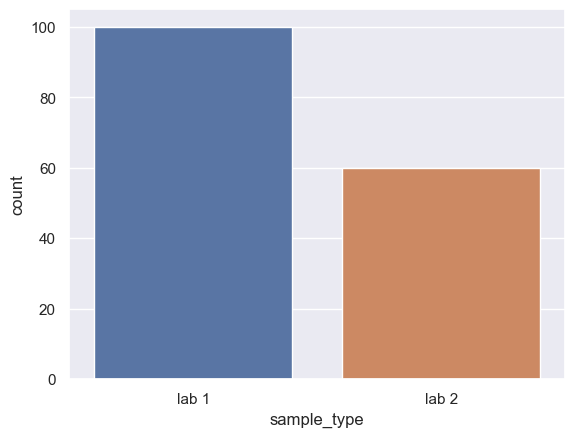

In [8]:
# plot the number of data according to lab which they were sampled from
sns.countplot(x='sample_type',data=df)

100 out of 160 data were sampled from lab 1 and the rest of 60 data entries were sampled from lab 2.

<AxesSubplot: xlabel='sample_type'>

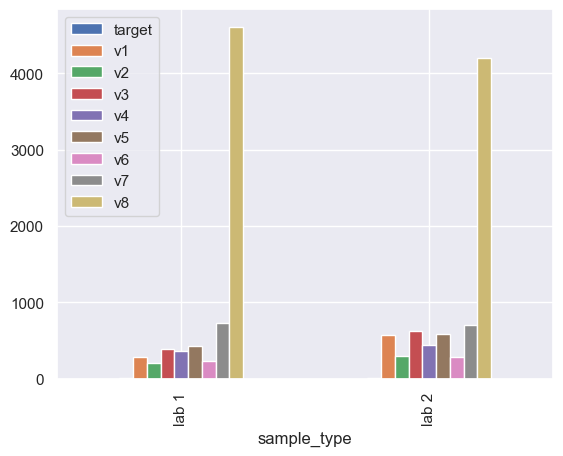

In [9]:
df.groupby(by='sample_type').mean().plot(kind='bar')

Each type's mean nutritional value (V1, V2, V3,... V8) varies. From the graph above, the mean nutritional values sampled by Lab 1 are generally higher than those of Lab 2 for all types except V8, which is higher in Lab 2.

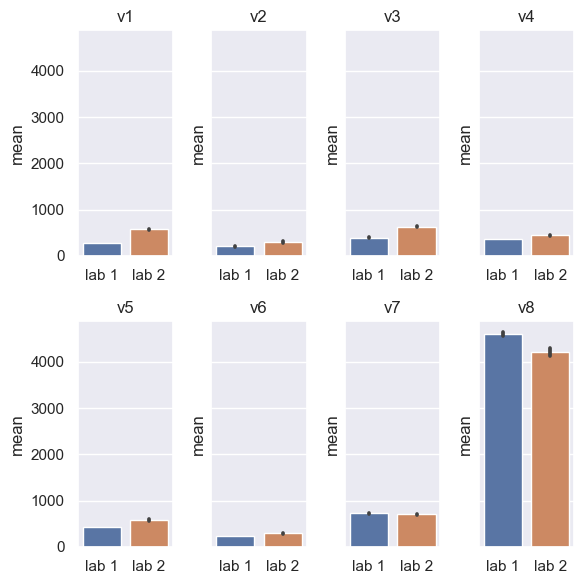

In [10]:
# plot side by side comparison
column_names = df.columns.to_list()
nutrition_columns = column_names[1:]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(6, 6), sharey=True)
# flatten the axes array for easier iteration
axs = axs.flatten()

#plot each nutritional type for and compare for each lab
for i, ax in enumerate(axs):
    sns.barplot(x="sample_type", y=df.iloc[:,i+1], data=df, ax=ax)
    ax.set_title(f'{nutrition_columns[i]}')
    ax.set_xlabel('')
    ax.set_ylabel('mean')

# adjust the layout and spacing of the subplots
plt.tight_layout()

# show the plot
plt.show()

A side-by-side comparison reveals that the data sampled by lab 2 has a higher mean than the data sampled by lab 1. 

In [11]:
# define all numerical columns
all_num_col = df.select_dtypes(include='number').columns.to_list()
all_num_col

['target', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8']

In [12]:
# construct titles for plotting
titles = []
for i in range(len(all_num_col)):
    titles.append('Distribusi ' + all_num_col[i])

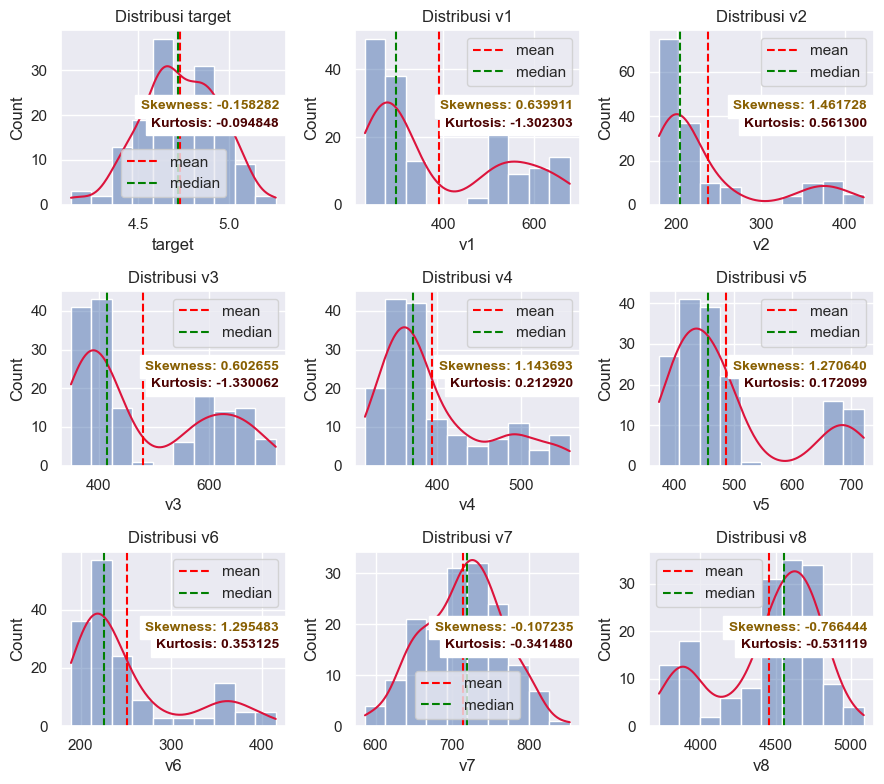

In [13]:
def plot_dist_num_col(df,row_num,col_num,num_col,figsize):
    # plot distribusi kolom numerik
    fig, axes= plt.subplots(row_num,col_num, figsize=figsize)

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.8)
    x=0
    for i in range(row_num):
        for j in range(col_num):
            sns.histplot(ax=axes[i][j], data=df[num_col[x]], kde=True, bins=10)
            axes[i][j].set_title(titles[x])
            axes[i][j].lines[0].set_color('crimson')
            axes[i][j].axvline(df[num_col[x]].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
            axes[i][j].axvline(df[num_col[x]].median(), color = 'green', linestyle = 'dashed', label = 'median')
            axes[i][j].legend()
            axes[i][j].text(x=0.97, y=0.60, transform=axes[i][j].transAxes, s="Skewness: %f" % df[num_col[x]].skew(),\
            fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
            backgroundcolor='white', color='xkcd:poo brown')
            axes[i][j].text(x=0.97, y=0.50, transform=axes[i][j].transAxes, s="Kurtosis: %f" % df[num_col[x]].kurt(),\
            fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
            backgroundcolor='white', color='xkcd:dried blood')
            x+=1
    plt.tight_layout()

# plot all distribution for numerical data
plot_dist_num_col(df=df,row_num=3,col_num=3,num_col=all_num_col,figsize=(9,8))

Above is the histogram to show the distribution of all numerical columns; the **target** and **v7** columns are normally distributed; all others are skewed.

## Feature Selection

Select only features which correlates with target, higher values towards 1.00 means more correlated and lower values towards 0.0 means no correlation at all.

interval columns not set, guessing: ['target', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8']


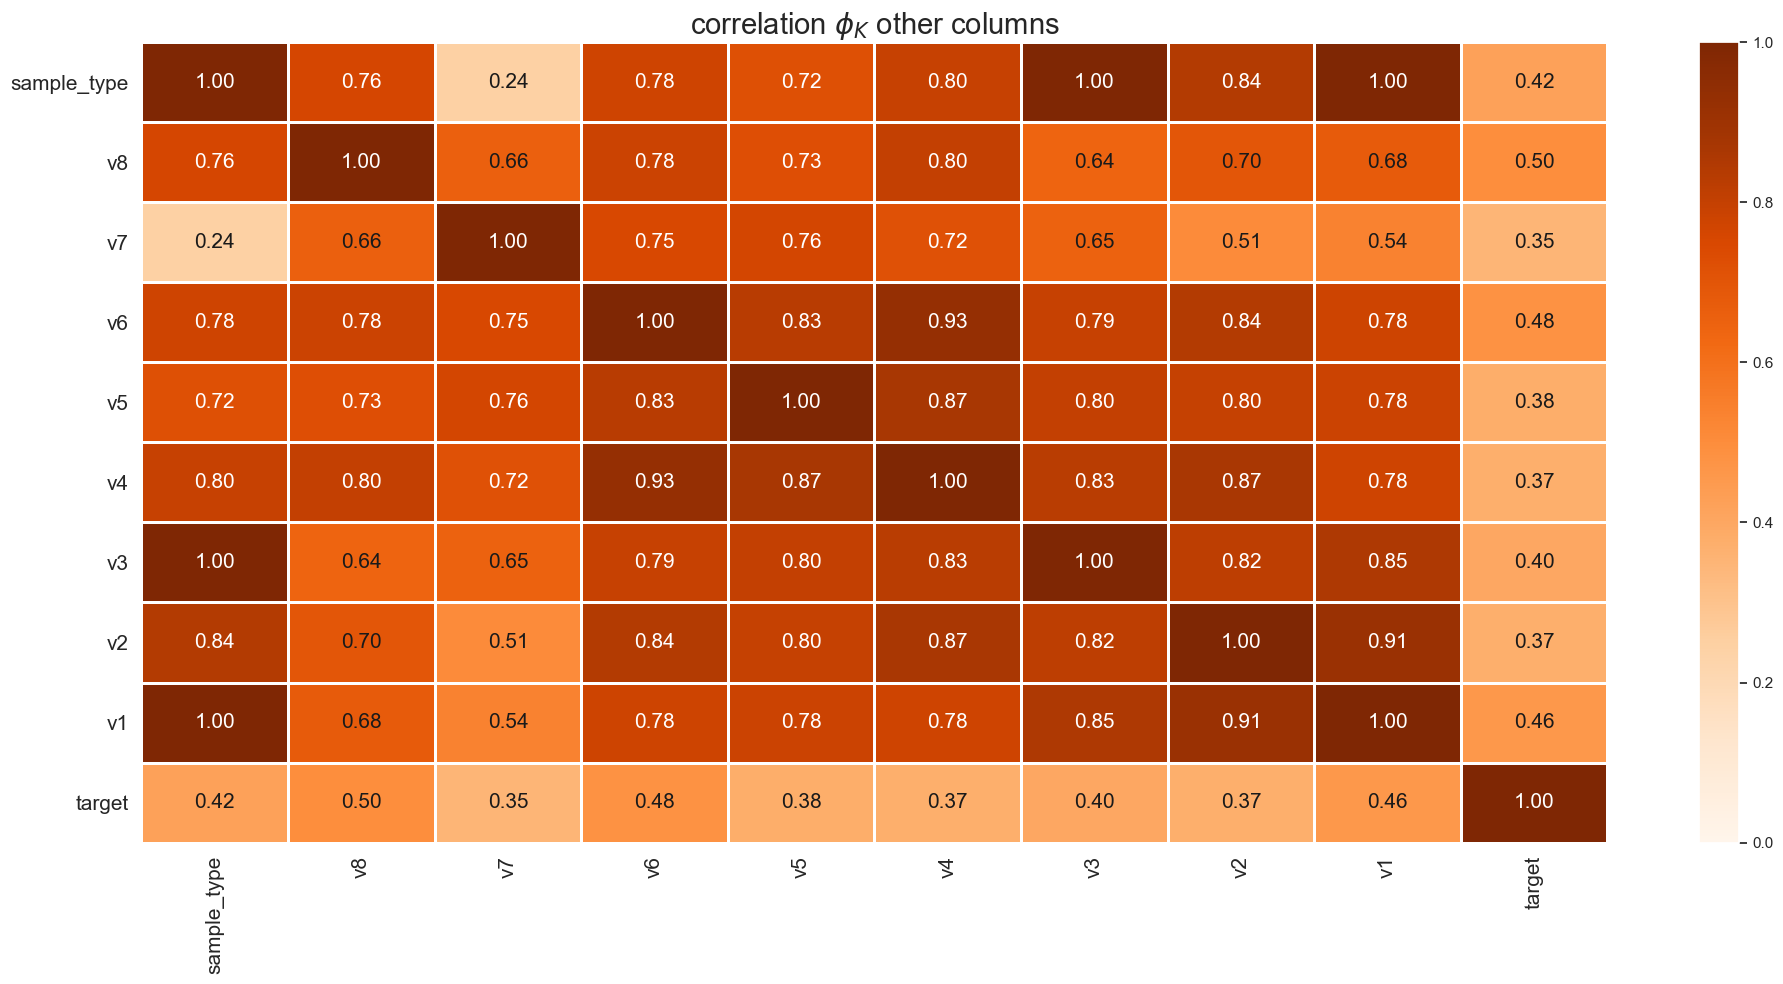

In [14]:
# get the phi_k correlation matrix between all variables
phik_matrix = df.phik_matrix()
plot_correlation_matrix(phik_matrix.values, 
                        x_labels=phik_matrix.columns, 
                        y_labels=phik_matrix.index, 
                        vmin=0, vmax=1, color_map="Oranges", 
                        title=r"correlation $\phi_K$ other columns", 
                        fontsize_factor=1.5,
                        figsize=(20,10))
plt.tight_layout()
# sns.heatmap(phik_matrix, annot= True, vmin=0, vmax=1, cmap='Accent', figsize=(12,8))

In [15]:
# cek all correlation with respect to target columns
df.phik_matrix().target.sort_values(ascending=False)

interval columns not set, guessing: ['target', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8']


target         1.000000
v8             0.499367
v6             0.480621
v1             0.459417
sample_type    0.424614
v3             0.401402
v5             0.378586
v4             0.374938
v2             0.373085
v7             0.348524
Name: target, dtype: float64

Looks like all columns are quite highly correlated with target, no need to drop a feature.

## Data Preprocessing

### Train-test Split
We split train and test set for evaluation purposes

In [16]:
# split between features and target
X = df.drop('target',axis=1)
y = df['target']

In [17]:
# split train-test at 80:20 
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42)
print(f'train size: {X_train.shape}')
print(f'test size: {X_test.shape}')

train size: (128, 9)
test size: (32, 9)


### Define numerical and categorical column(s)
We define numerical and categorical feature for later to be handled separately

In [18]:
# keep track of categorical column(s)
cat_col = X_train.select_dtypes(include='object').columns.to_list()
cat_col

['sample_type']

In [19]:
# keep track of numerical column(s) as well
num_col = X_train.select_dtypes(include='number').columns.to_list()
num_col

['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8']

## Feature Engineering
We then proceed to check the outliers (if any) and handle them appropriately. For outliers that are below 5%, we can just trim them because they are relatively small; otherwise, we will cap them using a winsorizer.

### Outlier checking
Outlier checking using IQR method which treats outlier if the values exceeds a specific range beyond Q3 and before Q1

In [20]:
# function to plot histogram and its boxplot for each feature.
def plot_diagnostic(df, col):
    fig, axes = plt.subplots(ncols = 2, figsize = (10, 4))
    
    # histogram
    sns.histplot(df[col], ax = axes[0], bins=10)
    axes[0].set_title(f"Histogram '{col}'")
    axes[0].axvline(df[col].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
    axes[0].axvline(df[col].median(), color = 'green', linestyle = 'dashed', label = 'median')
    axes[0].legend()
    
    # boxplot
    sns.boxplot(x=df[col], ax = axes[1], whis=1.5, orient='h')
    axes[1].set_title(f"Boxplot '{col}'")
    
    plt.show()
    
    # skewness
    print(df[col].name + ' Kurtosis: ' + str(df[col].kurt()))
    print(df[col].name + ' Skewness: ' + str(df[col].skew()))
    if -0.5 <= df[col].skew() <= 0.5:
        print("Columns '{}' is normally distributed".format(col))
    elif df[col].skew() > 0.5 and df[col].skew() <= 1 :
        print("Columns '{}' is moderately right skewed".format(col))
    elif df[col].skew() > 1:
        print("Columns '{}' is highly right skewed".format(col))
    elif df[col].skew() < -0.5 and df[col].skew() >= -1 :
        print("Columns '{}' is moderately left skewed".format(col))
    elif df[col].skew() < -1:
        print("Columns '{}' is highly left skewed".format(col))

In [21]:
# function to get upper and lower boundary values from a feature distribution
def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

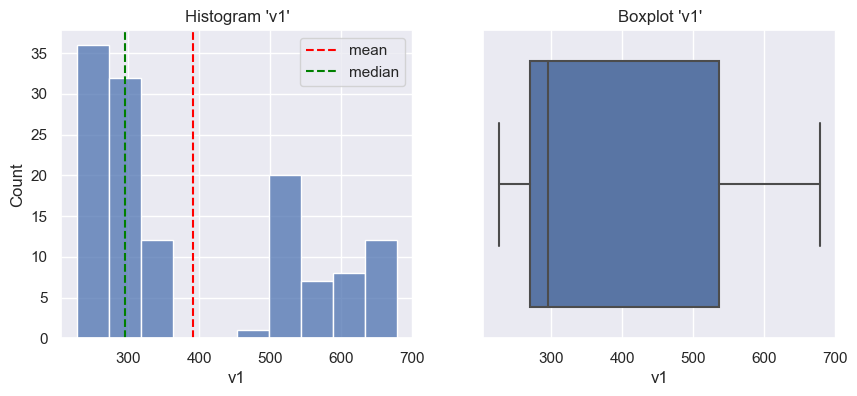

v1 Kurtosis: -1.3085327188490032
v1 Skewness: 0.6370045772170199
Columns 'v1' is moderately right skewed


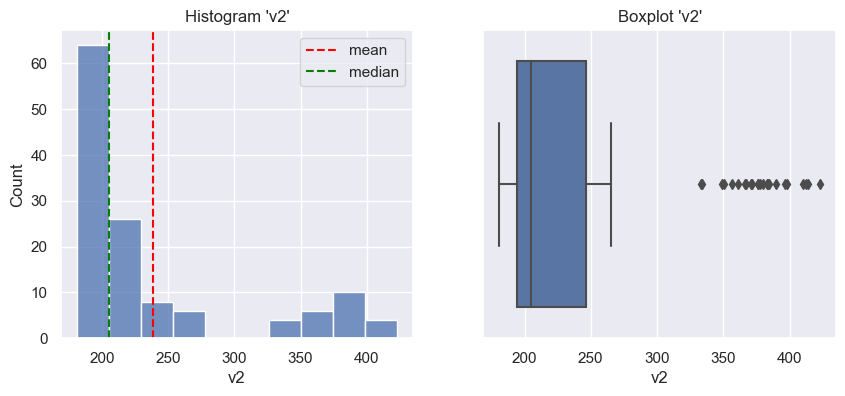

v2 Kurtosis: 0.5829236103427107
v2 Skewness: 1.464926607874351
Columns 'v2' is highly right skewed


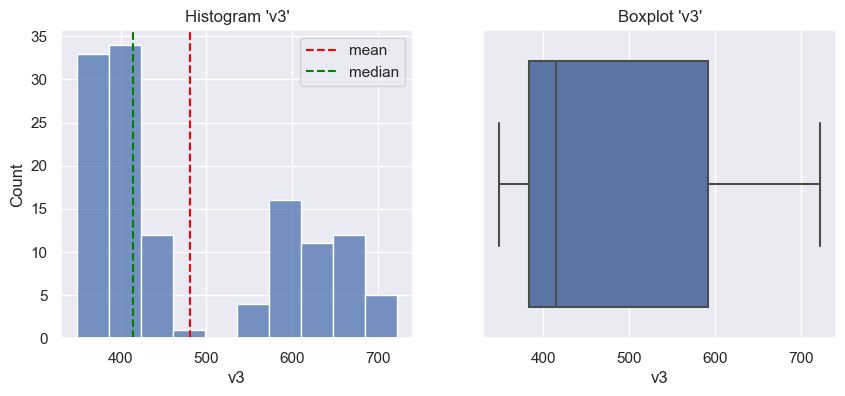

v3 Kurtosis: -1.3451313292114988
v3 Skewness: 0.5934410761547237
Columns 'v3' is moderately right skewed


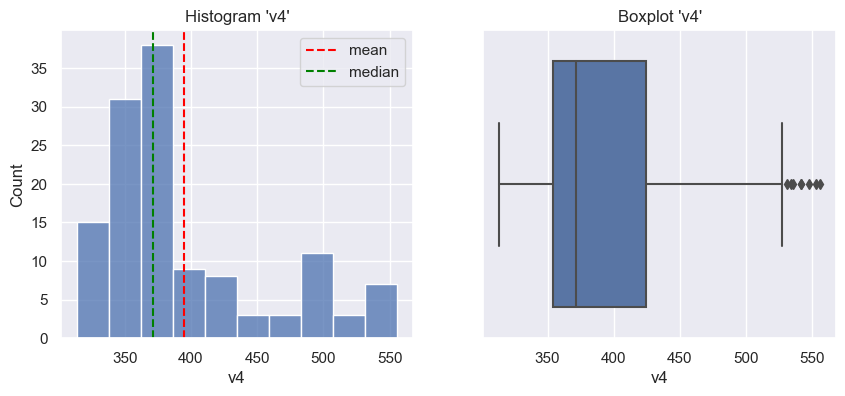

v4 Kurtosis: 0.21073924087673213
v4 Skewness: 1.1367295725287654
Columns 'v4' is highly right skewed


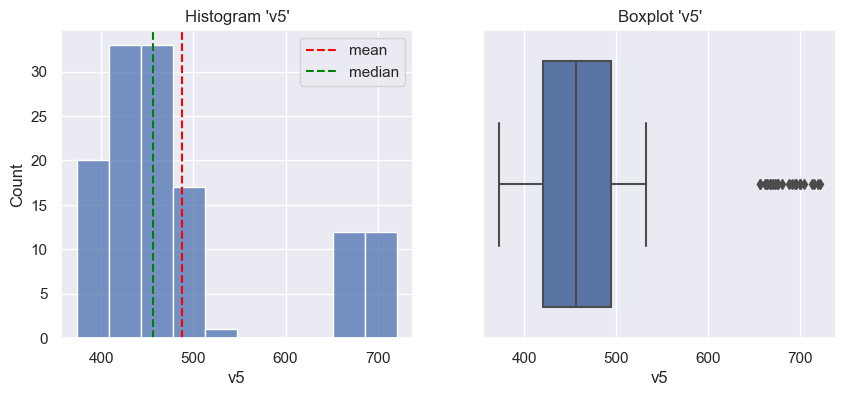

v5 Kurtosis: 0.21449358779651284
v5 Skewness: 1.284110655345764
Columns 'v5' is highly right skewed


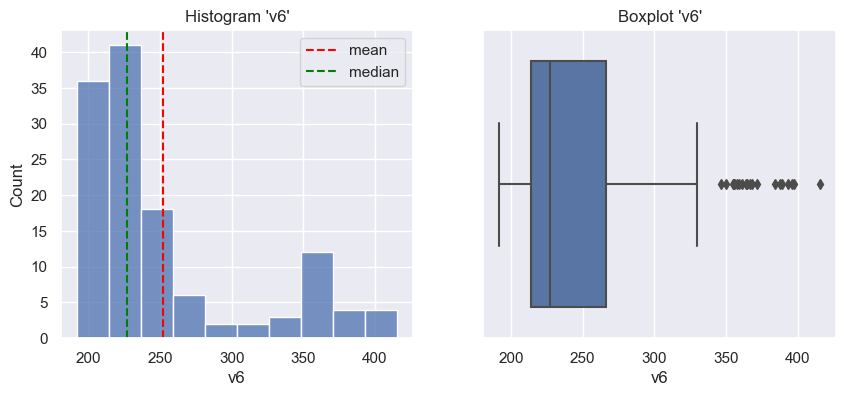

v6 Kurtosis: 0.351476694730501
v6 Skewness: 1.2998485149654015
Columns 'v6' is highly right skewed


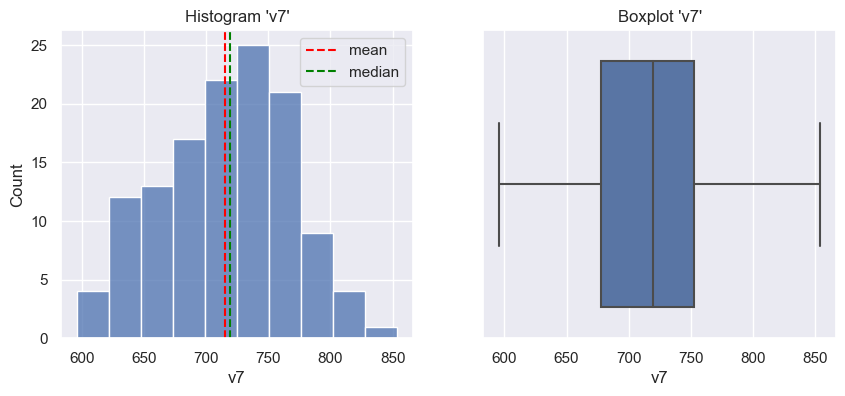

v7 Kurtosis: -0.39745701717355786
v7 Skewness: -0.11868512728413298
Columns 'v7' is normally distributed


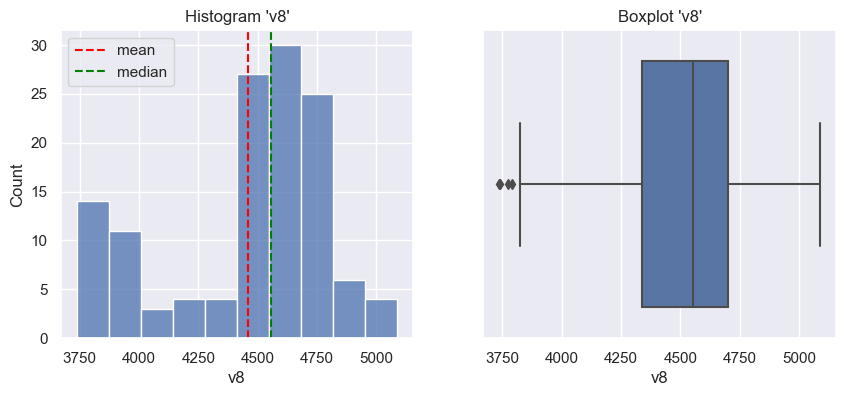

v8 Kurtosis: -0.5127113653698485
v8 Skewness: -0.7726620600289235
Columns 'v8' is moderately left skewed


In [22]:
# plot all features in X_train to see their distribution and outliers if any.
for i in range(len(num_col)):
    plot_diagnostic(X_train, num_col[i])

In [23]:
# variables to keep upper and lower limit from all numerical features
upper = []
lower = []

# keep upper and lower value inside list that was previously created
for i in range(len(num_col)):
    upper_, lower_ = find_skewed_boundaries(df=df, variable=num_col[i], distance=1.5)
    upper.append(upper_)
    lower.append(lower_)

# simpan value upper dan lower ke dictionary sesuai nama fiturnya dengan format (nama_fitur: upper,lower)
low_up_dict = {}
for i in range(len(num_col)):
    low_up_dict[num_col[i]]=[lower[i],upper[i]]

In [24]:
# show upper and lower value limit from each numerical feature
low_up_dict

{'v1': [-133.0932291666674, 938.1109375000003],
 'v2': [117.99754464285785, 320.74813988095093],
 'v3': [73.63200187970011, 902.3990444862138],
 'v4': [246.75625000000068, 530.5562499999988],
 'v5': [301.7458333333335, 613.3124999999994],
 'v6': [138.703125, 336.828125],
 'v7': [568.7932291666656, 861.0390625000008],
 'v8': [3632.6749999999965, 5341.375000000001]}

In [25]:
#list containing outliers percentage
trimmed_outliers = []
censored_outliers = []
# menghitung dan menampilkan persentase outlier dari tiap fitur
for i in range(len(num_col)):
    num_outlier = df[num_col[i]][(df[num_col[i]] > upper[i]) | (df[num_col[i]] < lower[i])].shape[0]
    outlier_percentage = num_outlier/df.shape[0]*100
    if outlier_percentage==0:
        pass
    elif (outlier_percentage>0.0 and outlier_percentage<=5.0):
        trimmed_outliers.append([num_col[i],outlier_percentage])
    else:
        censored_outliers.append([num_col[i],outlier_percentage])

print("Trimmed Outliers Consideration:")
for i in trimmed_outliers:
    print(f'\tPercentage of outlier in \033[1m{i[0]}\033[0m is {i[1]:.2f}%')

print("Censored Outliers Consideration:")
for i in censored_outliers:
    print(f'\tPercentage of outlier in \033[1m{i[0]}\033[0m is {i[1]:.2f}%')

Trimmed Outliers Consideration:
Censored Outliers Consideration:
	Percentage of outlier in v2 is 18.75%
	Percentage of outlier in v4 is 6.25%
	Percentage of outlier in v5 is 18.75%
	Percentage of outlier in v6 is 16.25%


### Outlier Handling
All of the outliers fall within the range of censored or capped consideration because they exceed 5%.

#### Capping
Winsorizing is the method used for capping and censoring. 

In [26]:
# define kolom yang ingin di cap
capped_col = [i[0] for i in censored_outliers]

# Create the capper
windsoriser = Winsorizer(capping_method='iqr',
                          tail='both', # cap left, right or both tails 
                          fold=1.5,
                          variables=capped_col)

# melakukan capping pada data train
X_train_t = windsoriser.fit_transform(X_train)

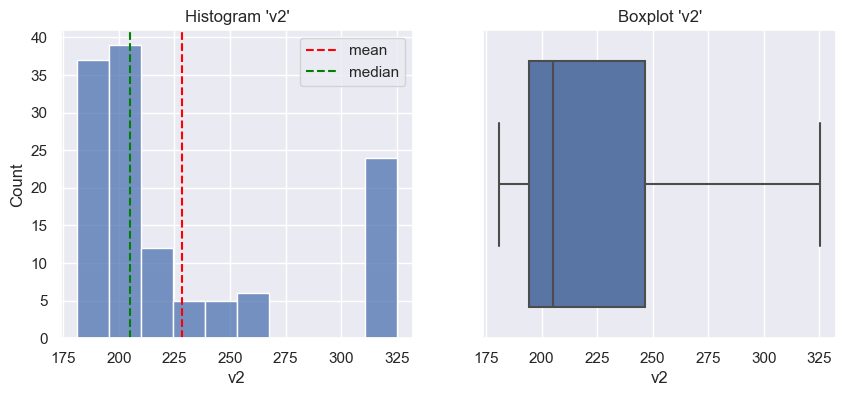

v2 Kurtosis: -0.17958333050019082
v2 Skewness: 1.1937588314368255
Columns 'v2' is highly right skewed


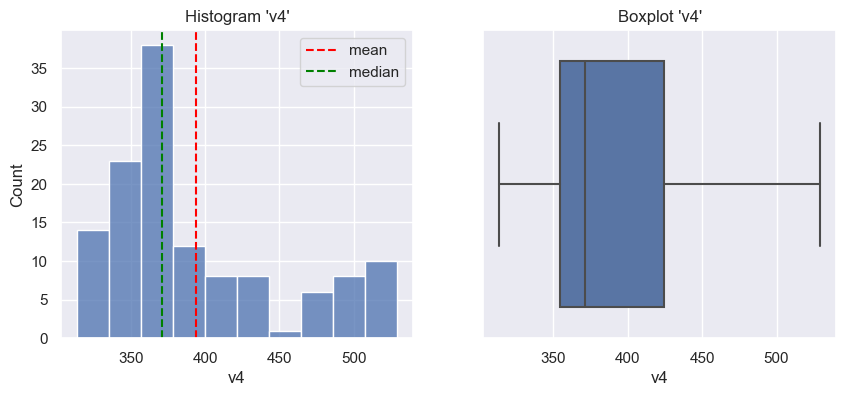

v4 Kurtosis: -0.06814997045176163
v4 Skewness: 1.0540582520363657
Columns 'v4' is highly right skewed


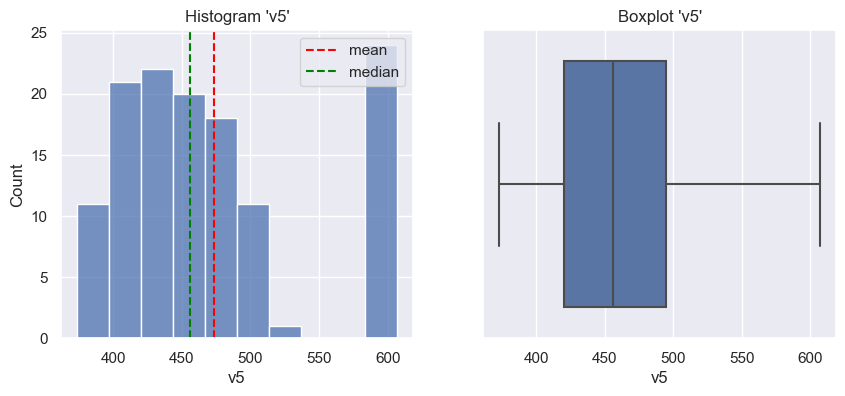

v5 Kurtosis: -0.37100312627923104
v5 Skewness: 0.9345666588945178
Columns 'v5' is moderately right skewed


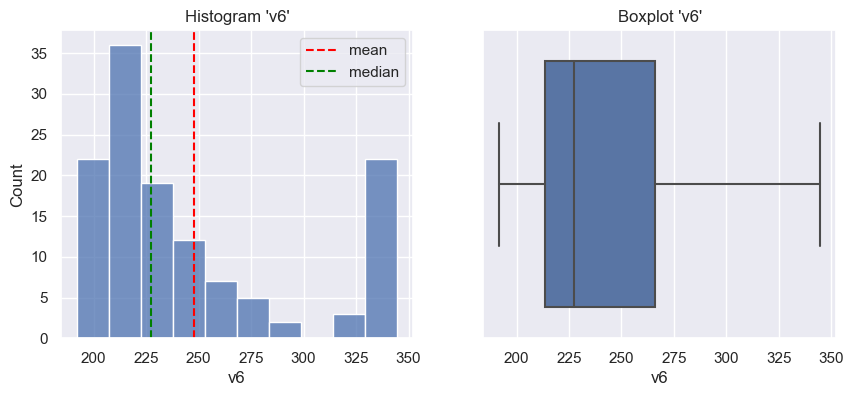

v6 Kurtosis: -0.32947418371571535
v6 Skewness: 1.06869846903832
Columns 'v6' is highly right skewed


In [27]:
# check outlier after capping
for i in range(len(capped_col)):
    plot_diagnostic(X_train_t, capped_col[i])

Now all the outliers have been capped.

### Encoding & Scaling
- All the numerical features will be scaled with **minmax scaler** instead of **standard scaler** the reason is because most of the numerical features distribution is not normally distributed another reason is to normalize the range and distribution of features in a dataset. This is because machine learning algorithms typically work better when the input data is on the same scale. 

- For the categorical feature which is only **sample_type** will be ordinally encoded because it only contains 2 unique values, otherwise we will use one-hot encoder. Encoding is needed because: By encoding categorical data into numerical format, machine learning models can process the data and use it to learn patterns and make predictions. Without encoding, machine learning models would be unable to process the categorical data, and important information could be lost.
- All the preprocessings are wrapped inside sklearn's **column transformer** as a **preprocessor** to make the it more seamless.

In [28]:
# define scaler and encoder
num_transformer = MinMaxScaler()
cat_transformer = OrdinalEncoder()
 
# wrap inside column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_col), 
        ("num", num_transformer, num_col),
    ],
    # remainder='passthrough'
    remainder='drop'
)

## Model Definition
- For this regression task, the models that will be used are the followings: `Linear Regression`, `Polynomial Regression`, `Support Vector Regression (SVR)`, `Decision Tree Regressor`, `Random Forest Regressor`, `Gradient Boosting Regressor`, `XGBoost Regressor`, and `CatBoost Regressor`.
- A pipeline is used in conjunction with previous data preprocessors to ensure a seamless process.
- All models will be evaluated and the best one will be chosen.

In [29]:
# instansiasi classifier dengan default parameter
linreg_model = LinearRegression()
poly_model = LinearRegression()
svr_model = SVR()
dtree_model = DecisionTreeRegressor(random_state=42)
rndforest_model = RandomForestRegressor(random_state=42)
gbr_model = GradientBoostingRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)
catb_model = CatBoostRegressor(silent=True,random_state=42)

In [30]:
# contruct data training pipeline (preprocessing + model fitting)
linreg_pipe = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("estimator",linreg_model)
    ]
)

poly = PolynomialFeatures(degree=4)
poly_pipe = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("poly_transform",poly),
        ("estimator",poly_model)
    ]
)

svr_pipe = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("estimator",svr_model)
    ]
)
dtree_pipe = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("estimator",dtree_model)
    ]
)
rndforest_pipe = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("estimator",rndforest_model)
    ]
)
gbr_pipe = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("estimator",gbr_model)
    ]
)
xgb_pipe = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("estimator",xgb_model)
    ]
)
catb_pipe = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("estimator",catb_model)
    ]
)

## Model Training
Fit all models using train set, and evaluate their performance.

In [31]:
# fit data train into model
linreg_pipe.fit(X_train_t,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['sample_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['v1', 'v2', 'v3', 'v4', 'v5',
                                                   'v6', 'v7', 'v8'])])),
                ('estimator', LinearRegression())])

In [32]:
poly_pipe.fit(X_train_t,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['sample_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['v1', 'v2', 'v3', 'v4', 'v5',
                                                   'v6', 'v7', 'v8'])])),
                ('poly_transform', PolynomialFeatures(degree=4)),
                ('estimator', LinearRegression())])

In [33]:
svr_pipe.fit(X_train_t,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['sample_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['v1', 'v2', 'v3', 'v4', 'v5',
                                                   'v6', 'v7', 'v8'])])),
                ('estimator', SVR())])

In [34]:
dtree_pipe.fit(X_train_t,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['sample_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['v1', 'v2', 'v3', 'v4', 'v5',
                                                   'v6', 'v7', 'v8'])])),
                ('estimator', DecisionTreeRegressor(random_state=42))])

In [35]:
rndforest_pipe.fit(X_train_t,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['sample_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['v1', 'v2', 'v3', 'v4', 'v5',
                                                   'v6', 'v7', 'v8'])])),
                ('estimator', RandomForestRegressor(random_state=42))])

In [36]:
gbr_pipe.fit(X_train_t,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['sample_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['v1', 'v2', 'v3', 'v4', 'v5',
                                                   'v6', 'v7', 'v8'])])),
                ('estimator', GradientBoostingRegressor(random_state=42))])

In [37]:
xgb_pipe.fit(X_train_t,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['sample_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['v1', 'v2', 'v3', 'v4', 'v5',
                                                   'v6', 'v7', 'v8'])])),
                ('estimator',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_catego...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=42, ...))])

In [38]:
catb_pipe.fit(X_train_t,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['sample_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['v1', 'v2', 'v3', 'v4', 'v5',
                                                   'v6', 'v7', 'v8'])])),
                ('estimator',
                 <catboost.core.CatBoostRegressor object at 0x29d58da20>)])

## Model Evaluation
Evaluate all models without cross validation

In [39]:
# state all used models
all_models = [linreg_pipe, poly_pipe, svr_pipe, dtree_pipe, rndforest_pipe, gbr_pipe, xgb_pipe, catb_pipe]
all_models_name = ['linreg', 'polyreg', 'svr', 'dtree', 'rndforest', 'gbr', 'xgb', 'catboost']

In [40]:
# evaluate on train-set
best_model_train = ''
best_r2_train = -1
train_predictions = [model.predict(X_train_t) for model in all_models]
print('------Train------')
for pred,model_name in zip(train_predictions,all_models_name):
    mae = mean_absolute_error(y_train,pred)
    mse = mean_squared_error(y_train,pred)
    r2 = r2_score(y_train,pred)
    print(f'model_name: {model_name}')
    print('MAE:',mae)
    print('MSE:',mse)
    print("R2 Score:",r2)
    print('-'*20)
    if r2 > best_r2_train:
        best_r2_train = r2
        best_model_train = model_name

# evaluate on test-set
best_model_test = ''
best_r2_test = -1
test_predictions = [model.predict(X_test) for model in all_models]
print('\n\n------Test------')
for pred,model_name in zip(test_predictions,all_models_name):
    mae = mean_absolute_error(y_test,pred)
    mse = mean_squared_error(y_test,pred)
    r2 = r2_score(y_test,pred)
    print(f'model_name: {model_name}')
    print('MAE:',mae)
    print('MSE:',mse)
    print("R2 Score:",r2)
    print('-'*20)
    if r2 > best_r2_test:
        best_r2_test = r2
        best_model_test = model_name

------Train------
model_name: linreg
MAE: 0.13327402808204866
MSE: 0.027267927172862784
R2 Score: 0.3340529281262352
--------------------
model_name: polyreg
MAE: 2.225233886044009e-13
MSE: 9.290300865735148e-26
R2 Score: 1.0
--------------------
model_name: svr
MAE: 0.12654071606077041
MSE: 0.024628983218514134
R2 Score: 0.39850216139932493
--------------------
model_name: dtree
MAE: 0.0
MSE: 0.0
R2 Score: 1.0
--------------------
model_name: rndforest
MAE: 0.054914843749999914
MSE: 0.004795108984374977
R2 Score: 0.8828921330463989
--------------------
model_name: gbr
MAE: 0.034584112898034564
MSE: 0.0017746556439295733
R2 Score: 0.9566587250227325
--------------------
model_name: xgb
MAE: 0.0007661509513854983
MSE: 1.2381281898000825e-06
R2 Score: 0.9999697619904375
--------------------
model_name: catboost
MAE: 0.01687905069761795
MSE: 0.0003996316055157091
R2 Score: 0.9902400539713098
--------------------


------Test------
model_name: linreg
MAE: 0.19133317214885778
MSE: 0.0504349

In [41]:
print(f'---Train---')
print(f'best model: {best_model_train}')
print(f'R2 score: {best_r2_train}')

print(f'---Test---')
print(f'best model: {best_model_test}')
print(f'R2 score: {best_r2_test}')

---Train---
best model: polyreg
R2 score: 1.0
---Test---
best model: gbr
R2 score: 0.3767608258515819


## Nutritional Component Evaluation
Evaluation on plant nutrition factor based on linear regression coefficient

In [42]:
print("Model slope:    ", linreg_pipe.named_steps['estimator'].coef_)
print("Model intercept:", linreg_pipe.named_steps['estimator'].intercept_)

Model slope:     [-0.27880582 -0.02293734 -0.36851424  0.56059679 -0.08286758  0.57045213
 -0.31002678 -0.27585689  0.11734814]
Model intercept: 4.731715246793353


Based on the coeffient values, components `v4` (0.56) and `v6` (0.57) have the `biggest significance` in `increasing the plant nutritional target` value, while `v1`, `v7`, and `v8` contribute to a `lower nutritional value`. As for the value of `v2`, `v5` and `sample_type` are relatively small, it `did not cause any significant impact` on the nutritional value.

The value of `intercept` is `4.73`, meaning that without any component added, say, `v1 to v8`, which have the value of `zero`, then the `default` plant nutritional value will be `4.73`.

In short, based on the linear regression data, if we want to `increase` the plant's nutritional value, we should use components `v4` and `v6`, and `avoid` using components `v1`, `v7`, and `v8`, as they decrease the plant's nutritional value.

## Model Evaluation with Cross Validation
Trains all models using cross-validation with the default parameter. Next, the best model is selected for hyperparameter tuning, and finally, the model's performance is compared before and after tuning to assess the improvements made. R2 score or coefficient determination is the metric that I used as it assess the goodness-of-fit of a regression model with 1.0 is the highest score (perfect fit).

In [43]:
all_models = [linreg_pipe, poly_pipe, svr_pipe, dtree_pipe, rndforest_pipe, gbr_pipe, xgb_pipe, catb_pipe]
all_models_name = ['linreg', 'polyreg', 'svr', 'dtree', 'rndforest', 'gbr', 'xgb', 'catboost']
all_cv =[] # keep cross validation score for all models in this list

In [44]:
#set metric
metric = 'r2'
cv_split = 3 # cross validation split

# checking cross validation score for all models
all_cv = [cross_val_score(pipe, X_train_t, y_train, cv=cv_split, scoring=metric) for pipe in all_models]

name_model = []
cv_scores=0
for cv,name in zip(all_cv, all_models_name):
    print(name)
    print(f'{metric} - All - Cross Validation  : ', cv)
    print(f'{metric} - Mean - Cross Validation : ', cv.mean())
    print(f'{metric} - Std - Cross Validation  : ', cv.std())
    print(f'{metric} - Range of Test-Set       : ', (cv.mean()-cv.std()) , '-', (cv.mean()+cv.std()))
    print('-'*50)
    if cv.mean()>cv_scores:
        cv_scores = cv.mean() # replace previous cv_score with current better cv_score
        name_model = name # replace previous best model with current best model
    else:
        pass
print('best model:', name_model)
print('cross-val mean:', cv_scores)

linreg
r2 - All - Cross Validation  :  [0.24568231 0.28632112 0.07030699]
r2 - Mean - Cross Validation :  0.2007701416939395
r2 - Std - Cross Validation  :  0.0937313672266701
r2 - Range of Test-Set       :  0.1070387744672694 - 0.2945015089206096
--------------------------------------------------
polyreg
r2 - All - Cross Validation  :  [ -9.6415601  -23.05443467 -32.26453069]
r2 - Mean - Cross Validation :  -21.653508488696115
r2 - Std - Cross Validation  :  9.288761856272123
r2 - Range of Test-Set       :  -30.942270344968236 - -12.364746632423993
--------------------------------------------------
svr
r2 - All - Cross Validation  :  [0.18826919 0.40595474 0.18371284]
r2 - Mean - Cross Validation :  0.25931225407647945
r2 - Std - Cross Validation  :  0.10370857728135917
r2 - Range of Test-Set       :  0.15560367679512027 - 0.36302083135783864
--------------------------------------------------
dtree
r2 - All - Cross Validation  :  [-0.49133438 -0.36522523 -0.93034293]
r2 - Mean - Cross

Based of cross validation with n_split = 3, the best model is **SVR** with mean R2 score of 0.259

## Using Artificial Neural Network
This is our attempt of using deep learning for regression task.

In [45]:
# preprocess data before model fitting
X_train_ann = preprocessor.fit_transform(X_train_t)
X_test_ann = preprocessor.transform(X_test)

In [46]:
# define ANN sequential model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2048, name='hidden_1', kernel_regularizer='l2', activation='relu', input_shape=(X_train_ann.shape[1],)),
    tf.keras.layers.Dense(1024, name='hidden_2', kernel_regularizer='l2', activation='relu'),
    tf.keras.layers.Dense(512, name='hidden_3', kernel_regularizer='l2', activation='relu'),
    tf.keras.layers.Dense(1, name='output'),
],name='model_1')

# show model summary
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_1 (Dense)            (None, 2048)              20480     
                                                                 
 hidden_2 (Dense)            (None, 1024)              2098176   
                                                                 
 hidden_3 (Dense)            (None, 512)               524800    
                                                                 
 output (Dense)              (None, 1)                 513       
                                                                 
Total params: 2,643,969
Trainable params: 2,643,969
Non-trainable params: 0
_________________________________________________________________


2023-02-18 23:47:26.875361: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-18 23:47:26.875484: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


This is a custom model through trial and error:
- Input layer accepts 9 dimension input as to conform with our tabular dataset with 9 columns
- 1st hidden layer consists of 2048 neurons
- 2nd hidden layer consists of 1024 neurons
- 3rd hidden layer consists of 512 neurons
- Output layer consists of single output neuron without activation function specified or equivalent to linear activation function 
- There are over 2.6 Millions of total trainable parameter for this model.

In [47]:
# compile model with mse as loss function and R2 score as metric
model.compile(loss='mse', optimizer='adam', metrics=RSquare())

In [48]:
# define callback
callback= [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), # stop the training if no improvement after n times
    ModelCheckpoint('aria_regression.h5', monitor='val_loss', save_best_only=True), # save the best model after this callback is executed
]

In [49]:
# Train the model with 1000 epochs
history = model.fit(X_train_ann, y_train, validation_data=(X_test_ann,y_test), epochs=1000, batch_size=128, verbose=1)

Epoch 1/1000


2023-02-18 23:47:27.171282: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-18 23:47:27.550048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 790ms/step - loss: 43.3492 - r_square: -553.4431 - val_loss: 37.4224 - val_r_square: -274.3579
Epoch 2/1000
1/1 [==============================] - 0s 51ms/step - loss: 37.2807 - r_square: -423.2698 - val_loss: 31.1363 - val_r_square: -186.4883
Epoch 3/1000
1/1 [==============================] - 0s 44ms/step - loss: 30.9531 - r_square: -285.7630 - val_loss: 25.0436 - val_r_square: -101.0897


2023-02-18 23:47:27.874527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 4/1000
1/1 [==============================] - 0s 45ms/step - loss: 24.5119 - r_square: -144.5825 - val_loss: 23.1359 - val_r_square: -81.0242
Epoch 5/1000
1/1 [==============================] - 0s 43ms/step - loss: 21.5459 - r_square: -87.5816 - val_loss: 26.3924 - val_r_square: -142.0715
Epoch 6/1000
1/1 [==============================] - 0s 43ms/step - loss: 23.7445 - r_square: -156.5566 - val_loss: 24.5366 - val_r_square: -122.7427
Epoch 7/1000
1/1 [==============================] - 0s 42ms/step - loss: 22.2726 - r_square: -135.9243 - val_loss: 20.3450 - val_r_square: -66.5485
Epoch 8/1000
1/1 [==============================] - 0s 42ms/step - loss: 18.9047 - r_square: -68.7512 - val_loss: 17.5058 - val_r_square: -31.3531
Epoch 9/1000
1/1 [==============================] - 0s 42ms/step - loss: 16.7285 - r_square: -30.2732 - val_loss: 16.3669 - val_r_square: -22.5349
Epoch 10/1000
1/1 [==============================] - 0s 46ms/step - loss: 15.9878 - r_square: -26.2995 - val_loss

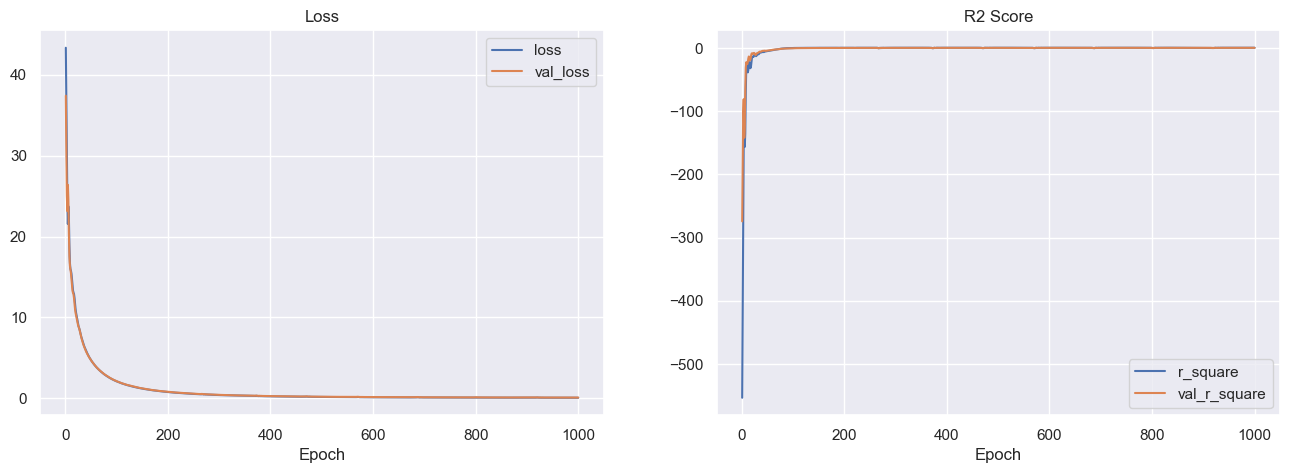

In [50]:
# plot val loss & recall
epoch=len(history.epoch)

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history.history['r_square'],label='r_square')
ax[1].plot(range(1,epoch+1),history.history['val_r_square'],label='val_r_square')
ax[1].set_title('R2 Score')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

In [51]:
# predict train & test set
y_pred_train = model.predict(X_train_ann)
y_pred_test = model.predict(X_test_ann)

1/1 [==============================] - 0s 12ms/step


2023-02-18 23:48:18.711973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [52]:
r2 = r2_score(y_train, y_pred_train)
print("R-squared score on train set:", r2)
r2 = r2_score(y_test, y_pred_test)
print("R-squared score on test set:", r2)

R-squared score on train set: 0.32257541862416206
R-squared score on test set: 0.21229953783196975


The results of using ANN model is not better than previous machine learning models. In fact, it is on par with linear regression model. Considering the higher computational cost, this model is inefficient.

## Model Tuning

Without cross validation or CV, the model that performs best on test set is  **GradientBoost Regressor** and with CV the model that performs best is **SVR**. However, **GradientBoost Regressor** scores higher than **SVR**, therefore we will fine-tune those model with **RandomSearchCV** and see if there is any improvement.

### SVR Hyperparameter Tuning

In [53]:
# choose tuning metric to be optimized for
metric_tuning = 'r2'

# parameter catboost
param_svr = {
    'estimator__kernel':['linear','poly','rbf','sigmoid'],
    'estimator__degree':[1,2,3,4,5,6],
    'estimator__gamma':['scale','auto'],
    'estimator__coef0':[1.0,0.6,0.2],
    'estimator__tol':[1e-1,1e-2,1e-3,1e-4,1e-5],
    'estimator__C':[1.0,0.5,1.5,2.0],
    'estimator__epsilon':[.1,.2,.3,.4,.5],
    'estimator__shrinking':[True,False],
    }

# tuning hyperparameter 
svr_randcv = RandomizedSearchCV(svr_pipe, param_distributions=param_svr, cv=5, n_iter=1000, scoring=metric_tuning, n_jobs=-1, random_state=42)
svr_randcv.fit(X_train_t, y_train)
print(f"SVR Model Hyperparameter Tuning...")
print(f"Best cross-validation {metric_tuning}: {svr_randcv.best_score_:.4f}")
print(f"R2 test set score: {svr_randcv.score(X_test, y_test):.4f}")
print(f"Best parameters: {svr_randcv.best_params_}")

SVR Model Hyperparameter Tuning...
Best cross-validation r2: 0.2265
R2 test set score: 0.2623
Best parameters: {'estimator__tol': 0.1, 'estimator__shrinking': False, 'estimator__kernel': 'rbf', 'estimator__gamma': 'scale', 'estimator__epsilon': 0.2, 'estimator__degree': 3, 'estimator__coef0': 0.2, 'estimator__C': 1.0}


The tuned SVR model achieved lower R2 score in training, from 0.398 to 0.226 but scores higher in test-set score, from 0.233 to 0.262. Overall the model still underfit even after tuning.

### Gradient Boost Regressor Hyperparameter Tuning

In [54]:
# choose tuning metric to be optimized for
metric_tuning = 'r2'

# parameter catboost
param_gbr = {
    'estimator__loss':['squared_error','absolute_error','huber','quantile'],
    'estimator__learning_rate':[0.1,0.2,0.05,0.01],
    'estimator__n_estimators':[50,100,200,300],
    'estimator__subsample':[1.0,0.6,0.2],
    'estimator__criterion':['friedman_mse','squared_error'],
    'estimator__min_samples_split':[2,3,4],
    'estimator__min_samples_leaf':[1,2,3],
    'estimator__min_weight_fraction_leaf':[0.0,0.2,0.5],
    'estimator__max_depth':[1,2,3,4,5],
    'estimator__ccp_alpha':[0.0,0.1,0.2,0.3,0.4,0.5],
    }

# tuning hyperparameter 
gbr_randcv = RandomizedSearchCV(gbr_pipe, param_distributions=param_gbr, cv=5, n_iter=1000, scoring=metric_tuning, n_jobs=-1, random_state=42)
gbr_randcv.fit(X_train_t, y_train)
print(f"Gradient Boost Regressor Model Hyperparameter Tuning...")
print(f"Best cross-validation {metric_tuning}: {gbr_randcv.best_score_:.4f}")
print(f"R2 test set score: {gbr_randcv.score(X_test, y_test):.4f}")
print(f"Best parameters: {gbr_randcv.best_params_}")

Gradient Boost Regressor Model Hyperparameter Tuning...
Best cross-validation r2: 0.2209
R2 test set score: 0.1916
Best parameters: {'estimator__subsample': 0.6, 'estimator__n_estimators': 50, 'estimator__min_weight_fraction_leaf': 0.2, 'estimator__min_samples_split': 3, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': 3, 'estimator__loss': 'absolute_error', 'estimator__learning_rate': 0.1, 'estimator__criterion': 'squared_error', 'estimator__ccp_alpha': 0.1}


The tuned GradientBoosting model achieved lower R2 score in training, from 0.95 to 0.22 also scores lower in test-set score, from 0.37 to 0.19. Overall the model performs worse after tuning and considered underfit.

## Model Saving

In [55]:
# save best model
with open('deployment/gbr.pkl','wb') as file_1:
    joblib.dump(gbr_pipe,file_1)

The chosen model is Gradient Boosting Regressor (GBR) with pros and cons as follows:<br><br>
Pros:
- High accuracy: GBR is known for its high accuracy, often outperforming other popular algorithms like linear regression and decision trees.
- Handles heterogeneous features: GBR can handle heterogeneous features well, such as a mix of numerical and categorical features, and missing values.
- Handles nonlinear relationships: GBR can model nonlinear relationships between features and the target variable, which makes it a good choice for many real-world problems.
- Regularization: GBR includes a regularization parameter that helps to prevent overfitting.
- Feature selection: GBR can be used for feature selection by examining the importance of each feature in the model.

Cons:
- Slow training time: GBR can be slow to train, especially on large datasets. This is because it trains many decision trees sequentially, and each tree is trained to correct the mistakes of the previous tree.
- Requires careful tuning: GBR has several hyperparameters that need to be carefully tuned to achieve optimal performance.
- Can overfit: GBR can overfit if the hyperparameters are not properly tuned or if the dataset is too small.
- Not interpretable: GBR can be difficult to interpret, especially when the model contains many trees. It can be challenging to understand the exact relationship between features and the target variable.

## Conclusion

- Generally, `mean nutritional values` sampled by `lab 2` is `higher` than `lab 1`.
- Component `v8` has a `far higher` mean nutritional component value than any other nutritional component, exceeding `4000` while other components never exceed `1000`.
- Nutritional `target` data and component `v7` are the only columns that are `normally distributed`.
- Over all models that I have tried, the model that performs best is `GradientBoosting Regressor`, which achieved `0.37 R2 score` towards `test-set`.
- The previously mentioned models still got an `overfitting problem`, which denoted by the `high gap` between R2 score in train-set which is **0.95** in train-set and **0.37** in test-set.
- Tuning the hyperparameter with **Random Search Cross Validation** did help the overfitting issues, but the performance got `worse` and is now considered `underfit`.
- Implementation on `Neural Network` based model achieved `similar` results with traditional `linear regression` model.
- Current best model is baseline **GradientBoosting Regressor** without tuning applied.
- Determining the components responsible for nutritional value is critical for `increasing crop yields` and, consequently, `revenue`.
- Based on the `linear regression` data, to `increase` the plant's `nutritional value`, we should use components `v4` and `v6`, and `avoid` using components `v1`, `v7`, and `v8`, as they `decrease` the plant's `nutritional value`.
- Without adding any components, the `default` plant nutrition will get a `4.7` score.

## Further Improvement

- Author believe that a lot more data is needed to make the model more accurate.